## Deep Neural Network model with OHE-PCA
*Summary:* In this notebook, we use a DNN model using PCA analysis. We use one-hot encoding for the categorical variables and reduce the dimensionality from a total of 196 features to 18 features, that retain the explanation of 95% of the variance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

In [3]:
df = pd.concat([train, test]).reset_index(drop=True)
labels = df['label']
df = df.drop(columns=['id', 'attack_cat', 'label'], axis=1)

# get numeric column names without label column
num_cols = df._get_numeric_data().columns

# subract numeric columns from all columns to get categorical columns 
cat_cols = list(set(df.columns) - set(num_cols))

print(f"Numerical features: {len(num_cols)}\nCategorical features: {len(cat_cols)}")

Numerical features: 39
Categorical features: 3


In [5]:
# label encoding for categorical features
df[cat_cols] = df[cat_cols].astype('category')
for cat in cat_cols:
    df[cat] = df[cat].cat.codes

df[cat_cols]

,service,proto,state
0,0,119,5
1,0,119,5
2,0,119,5
3,0,119,5
4,0,119,5
...,...,...,...
257668,2,119,5
257669,0,113,4
257670,2,119,5
257671,2,119,5


In [6]:
from sklearn.preprocessing import MinMaxScaler

# standard scale numerical features
scl = MinMaxScaler()
df = pd.DataFrame(scl.fit_transform(df), columns=df.columns)

(df.shape, labels.shape)

((257673, 42), (257673,))

In [7]:
from sklearn.cluster import KMeans
from sklearn import metrics

X_df = df
true_labels = labels.tolist()

n = len(X_df.columns)
HS = []

for i in range(n):
    c = KMeans(init='k-means++', n_init=2, n_clusters=2, random_state=42).fit_predict(X=X_df.iloc[:, i].to_frame())
    HS.append((i, metrics.homogeneity_score(true_labels, c)))

In [8]:
HS.sort(key=lambda x: x[1], reverse=True)
HS

[(9, 0.27081339129609183),
 (3, 0.20315394153774333),
 (31, 0.18077481690144054),
 (34, 0.12724618944869617),
 (19, 0.10433352549445511),
 (33, 0.10007383802996503),
 (22, 0.08953863263442809),
 (35, 0.08731017485893738),
 (32, 0.08555843047147933),
 (39, 0.08490454778243431),
 (40, 0.07631074051369509),
 (30, 0.07474917810770333),
 (12, 0.06553483721251299),
 (27, 0.05640037096181579),
 (8, 0.04943473480220102),
 (20, 0.042004327041065034),
 (21, 0.040182050970366825),
 (2, 0.033855079536718534),
 (41, 0.022524926003373393),
 (15, 0.019114131401228085),
 (10, 0.00624719012932368),
 (25, 0.0032625411332699193),
 (26, 0.001522207932326416),
 (0, 0.0010836545686128583),
 (1, 0.0009351417827060433),
 (38, 0.0007340868718277337),
 (16, 0.0005555648151862274),
 (11, 0.0003505320386845993),
 (4, 0.0003056499986170159),
 (6, 0.0003056499986170159),
 (13, 0.0003056499986170159),
 (18, 0.0002565152456023987),
 (5, 0.0001700796286120169),
 (7, 0.0001700796286120169),
 (14, 0.0001700796286120169)

In [9]:
# filter by selecting all features with a HS-score of > 0.1, then map to get feature index
feature_indices = list(map(lambda x: x[0], filter(lambda x: x[1] > 0.1, HS)))

# select only the selected features by index
df = df.iloc[:, feature_indices]
df

,sttl,state,ct_state_ttl,ct_dst_sport_ltm,swin,ct_src_dport_ltm
0,0.996078,0.5,0.333333,0.000000,0.0,0.000000
1,0.996078,0.5,0.333333,0.000000,0.0,0.000000
2,0.996078,0.5,0.333333,0.000000,0.0,0.000000
3,0.996078,0.5,0.333333,0.000000,0.0,0.017241
4,0.996078,0.5,0.333333,0.000000,0.0,0.017241
...,...,...,...,...,...,...
257668,0.996078,0.5,0.333333,0.266667,0.0,0.396552
257669,0.996078,0.4,0.166667,0.000000,1.0,0.000000
257670,0.996078,0.5,0.333333,0.044444,0.0,0.034483
257671,0.996078,0.5,0.333333,0.288889,0.0,0.500000


In [10]:
from sklearn.model_selection import train_test_split

y = labels
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

((162640, 6), (85033, 6), (10000, 6), (162640,), (85033,), (10000,))

### Tensorflow model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [7]:
model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid', use_bias=True)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 87,425
Trainable params: 87,425
Non-traina

In [8]:
model.compile('adam', loss='binary_crossentropy', metrics='accuracy')

monitor_val_acc = EarlyStopping(monitor='loss', patience=10)
callbacks=[PlotLossesKeras()]

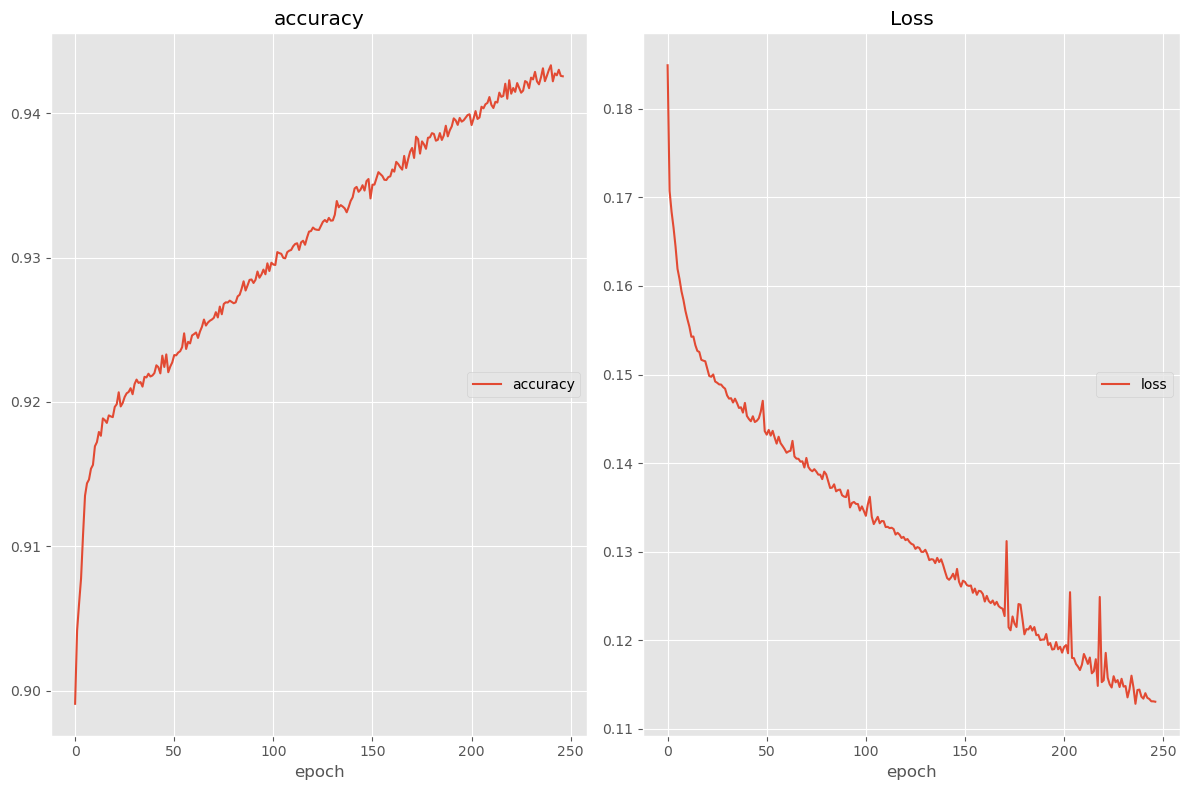

accuracy
	accuracy         	 (min:    0.899, max:    0.943, cur:    0.943)
Loss
	loss             	 (min:    0.113, max:    0.185, cur:    0.113)


In [10]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[PlotLossesKeras(), monitor_val_acc], shuffle=1000, verbose=0)

In [11]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 3s 1ms/step - loss: 0.1694 - accuracy: 0.9078


[0.1694270521402359, 0.9077887535095215]

In [12]:
model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid', use_bias=True)
    ]
)
model.summary()

model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1000, shuffle=1000, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 84,353
Trainable params: 84,353
Non-traina

In [13]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 3s 1ms/step - loss: 0.2185 - accuracy: 0.8982


[0.218463733792305, 0.8981807231903076]

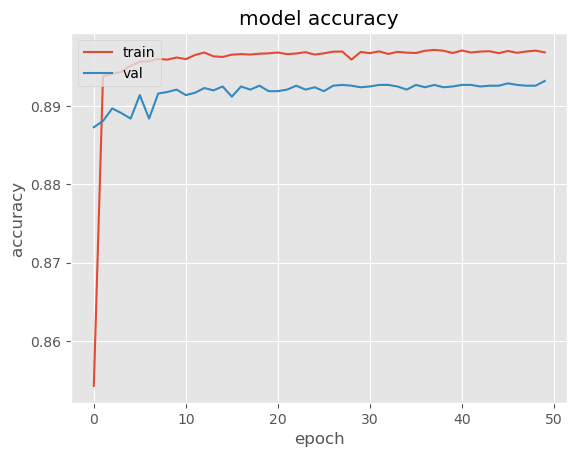

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

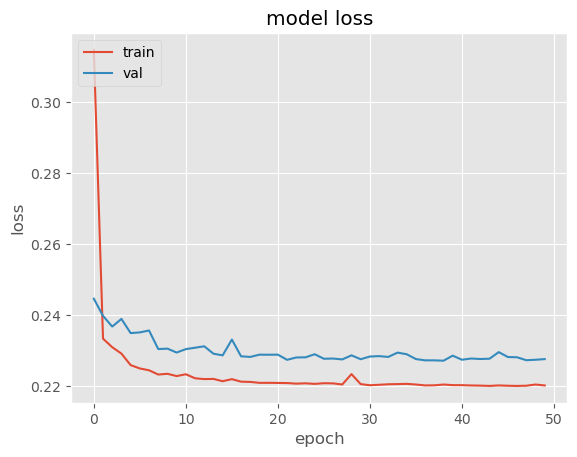

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()